In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


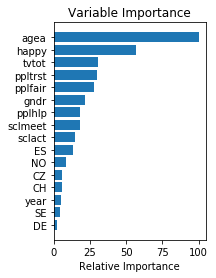

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Feature Selection

We will be using SelectKBest from sklearn to select features which explain most variance in our dataset. 10 features will be selected out of 16 which have most information.

In [5]:
# Feature selection
selector = SelectKBest(k=10).fit(X_train, y_train)

In [6]:
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

## Tuning parameters

Prameter tuning is done using GridSearchCV. It will automatically find optimal parameters from given values.

In [7]:
# GridSearchCV for selecting parameters\
# Params object for GridSearchCV
params = {'n_estimators': [100, 300, 500, 700],
          'max_depth': [1,2,4,8],
          'loss': ['deviance', 'exponential']}

# Create Gradient Boost instance
gboost = ensemble.GradientBoostingClassifier(random_state=44)

# Using GridSearchCV
CV_gboost = GridSearchCV(estimator=gboost, param_grid=params, cv=5)
CV_gboost.fit(X_train_new, y_train)

predict_train = CV_gboost.predict(X_train_new)
predict_test = CV_gboost.predict(X_test_new)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print(CV_gboost.best_params_)

Training set accuracy:
Percent Type I errors: 0.03205128205128205
Percent Type II errors: 0.21808510638297873

Test set accuracy:
Percent Type I errors: 0.04539877300613497
Percent Type II errors: 0.21717791411042944
{'loss': 'deviance', 'max_depth': 1, 'n_estimators': 100}


## Conclusion

From all the parameters, these are most efficient. We were able to reduce errors by a small fraction.

Increasing the number of estimators or increasing the max_depth could be resulting in overfitting. So, GridSearchCV ignored those as parameters.